In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN
import numpy as np

# Load the dataset
data = pd.read_csv('/kaggle/input/rfe-sarc/sarcopenia_dataset_rfe.csv')

# Define target and features
X = data.drop(columns=['sarcopenia_2'])
y = data['sarcopenia_2']

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply normalization (MinMaxScaler)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply standardization (StandardScaler) after normalization
standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train_scaled)
X_val_standardized = standardizer.transform(X_val_scaled)
X_test_standardized = standardizer.transform(X_test_scaled)

# Convert back to DataFrame for further processing
X_train = pd.DataFrame(X_train_standardized, columns=X.columns)
X_val = pd.DataFrame(X_val_standardized, columns=X.columns)
X_test = pd.DataFrame(X_test_standardized, columns=X.columns)

# Apply ADASYN for resampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Save preprocessed data
X_resampled.to_csv('/kaggle/working/X_resampled_adasyn.csv', index=False)
np.save('/kaggle/working/y_resampled_adasyn.npy', y_resampled)
X_test.to_csv('/kaggle/working/X_test.csv', index=False)
np.save('/kaggle/working/y_test.npy', y_test)
X_val.to_csv('/kaggle/working/X_val.csv', index=False)
np.save('/kaggle/working/y_val.npy', y_val)


Class distribution before ADASYN:
sarcopenia_2
0    524
1    140
Name: count, dtype: int64

Class distribution after ADASYN:
sarcopenia_2
1    301
0    297
Name: count, dtype: int64


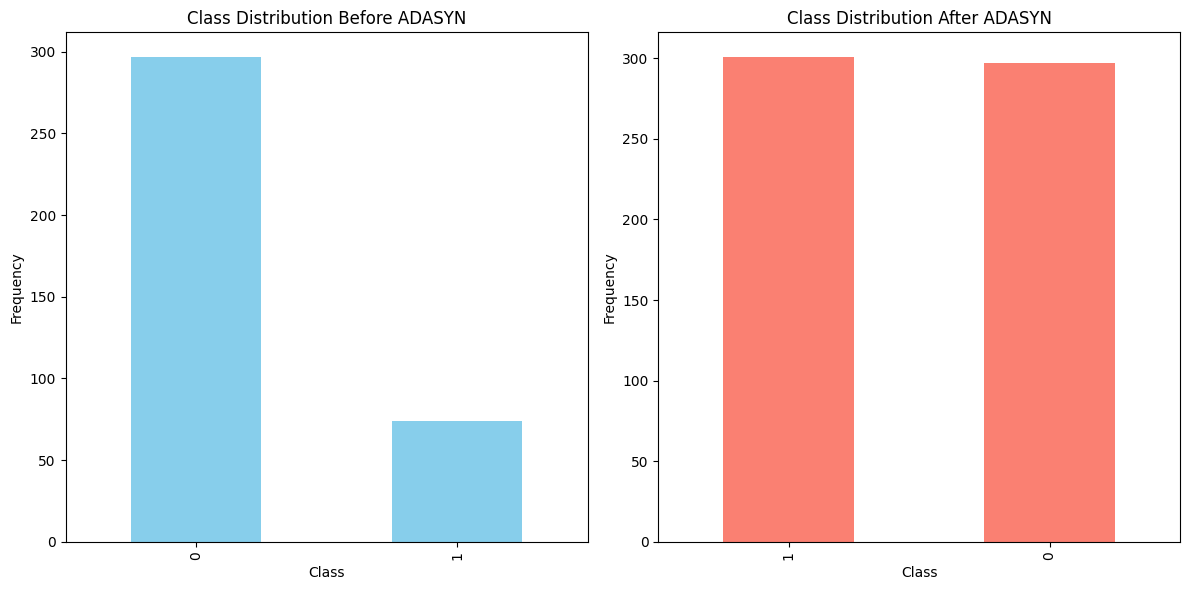

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/kaggle/input/rfe-sarc/sarcopenia_dataset_rfe.csv')

# Define target and features
X = data.drop(columns=['sarcopenia_2'])
y = data['sarcopenia_2']

# Print class distribution before ADASYN
print("Class distribution before ADASYN:")
print(y.value_counts())

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply normalization (MinMaxScaler)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply standardization (StandardScaler) after normalization
standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train_scaled)
X_val_standardized = standardizer.transform(X_val_scaled)
X_test_standardized = standardizer.transform(X_test_scaled)

# Convert back to DataFrame for further processing
X_train = pd.DataFrame(X_train_standardized, columns=X.columns)
X_val = pd.DataFrame(X_val_standardized, columns=X.columns)
X_test = pd.DataFrame(X_test_standardized, columns=X.columns)

# Apply ADASYN for resampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Print class distribution after ADASYN
print("\nClass distribution after ADASYN:")
print(y_resampled.value_counts())

# Save preprocessed data
X_resampled.to_csv('/kaggle/working/X_resampled_adasyn.csv', index=False)
np.save('/kaggle/working/y_resampled_adasyn.npy', y_resampled)
X_test.to_csv('/kaggle/working/X_test.csv', index=False)
np.save('/kaggle/working/y_test.npy', y_test)
X_val.to_csv('/kaggle/working/X_val.csv', index=False)
np.save('/kaggle/working/y_val.npy', y_val)

# Plot class distribution before and after ADASYN
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot before ADASYN
y_train.value_counts().plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Class Distribution Before ADASYN')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Plot after ADASYN
y_resampled.value_counts().plot(kind='bar', ax=ax[1], color='salmon')
ax[1].set_title('Class Distribution After ADASYN')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

# Save the plot
plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution_comparison.png')
plt.show()


# Hyperparameter

In [4]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import joblib
import numpy as np
from scipy.stats import randint, uniform

# Load preprocessed data
X_resampled = pd.read_csv('/kaggle/working/X_resampled_adasyn.csv')
y_resampled = np.load('/kaggle/working/y_resampled_adasyn.npy')

# Define parameter grids for each classifier
param_grids = {
    'SVM': {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'Random_Forest': {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
    },
    'Neural_Network': {
        'hidden_layer_sizes': [(50,), (50, 50), (100,)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd'],
        'alpha': uniform(0.0001, 0.01),
        'learning_rate': ['constant', 'adaptive'],
    },
    'Decision_Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
    },
    'KNN': {
        'n_neighbors': randint(1, 20),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 for Manhattan, p=2 for Euclidean
    },
    'Naive_Bayes': {
        'var_smoothing': uniform(1e-10, 1e-8)
    },
    'Logistic_Regression': {
        'C': uniform(0.1, 10),
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],  # saga solver for elasticnet
        'l1_ratio': uniform(0, 1)  # for elasticnet only
    }
}

# Initialize classifiers
classifiers = {
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Random_Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Neural_Network': MLPClassifier(random_state=42),
    'Decision_Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive_Bayes': GaussianNB(),
    'Logistic_Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

# Perform hyperparameter tuning using RandomizedSearchCV
best_classifiers = {}

for name, clf in classifiers.items():
    print(f"Tuning {name}...")
    param_grid = param_grids[name]
    random_search = RandomizedSearchCV(
        estimator=clf, 
        param_distributions=param_grid, 
        n_iter=50, 
        scoring='accuracy', 
        n_jobs=-1, 
        cv=5, 
        random_state=42,
        verbose=1
    )
    random_search.fit(X_resampled, y_resampled)
    best_classifiers[name] = random_search.best_estimator_
    joblib.dump(best_classifiers[name], f'/kaggle/working/{name}_best_tuned_classifier.joblib')
    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best accuracy for {name}: {random_search.best_score_:.4f}\n")

# best_classifiers now contains the best model for each type after hyperparameter tuning.


Tuning SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for SVM: {'C': 5.32732829381994, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy for SVM: 0.9481

Tuning Random_Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters for Random_Forest: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 196}
Best accuracy for Random_Forest: 0.9398

Tuning Neural_Network...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Best parameters for Neural_Network: {'activation': 'relu', 'alpha': 0.006068501579464871, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best accuracy for Neural_Network: 0.9499

Tuning Decision_Tree...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Decision_Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy for Decision_Tree: 0.9013

Tuning KNN...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for KNN: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best accuracy for KNN: 0.9331

Tuning Naive_Bayes...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Naive_Bayes: {'var_smoothing': 3.845401188473625e-09}
Best accuracy for Naive_Bayes: 0.8444

Tuning Logistic_Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_

Best parameters for Logistic_Regression: {'C': 0.2563640674119393, 'l1_ratio': 0.4234014807063696, 'penalty': 'l1', 'solver': 'saga'}
Best accuracy for Logistic_Regression: 0.9197



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_

In [5]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import joblib
import numpy as np

# Load preprocessed data
X_resampled = pd.read_csv('/kaggle/working/X_resampled_adasyn.csv')
y_resampled = np.load('/kaggle/working/y_resampled_adasyn.npy')

# Initialize classifiers with the best hyperparameters
classifiers = {
    'SVM': SVC(C=5.32732829381994, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=196, max_depth=20, max_features='auto', min_samples_leaf=1, min_samples_split=2, class_weight='balanced', random_state=42),
    'Neural_Network': MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', alpha=0.006068501579464871, learning_rate='constant', random_state=42),
    'Decision_Tree': DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=2, weights='distance', p=2),
    'Naive_Bayes': GaussianNB(var_smoothing=3.845401188473625e-09),
    'Logistic_Regression': LogisticRegression(C=0.2563640674119393, penalty='l1', solver='saga', l1_ratio=0.4234014807063696, class_weight='balanced', max_iter=1000, random_state=42)
}

# Train and save classifiers
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)
    joblib.dump(clf, f'/kaggle/working/{name}_adasyn_best_classifier.joblib')

print("Training complete. Models saved.")

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training complete. Models saved.


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Selected Models and their Performance Scores:
Model: SVM, Accuracy: 0.8700
Model: Random_Forest, Accuracy: 0.8600
Model: Neural_Network, Accuracy: 0.8750
Model: Decision_Tree, Accuracy: 0.8350
Model: KNN, Accuracy: 0.8300
Model: Naive_Bayes, Accuracy: 0.7700
Model: Logistic_Regression, Accuracy: 0.8500

Selected Models for Ensemble:
SVM
Random_Forest
Neural_Network
Decision_Tree
Logistic_Regression


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Final Selected Ensemble Accuracy: 0.8900

Classification Report for Selected Ensemble:
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93       153
    Positive       0.79      0.72      0.76        47

    accuracy                           0.89       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.89      0.89      0.89       200



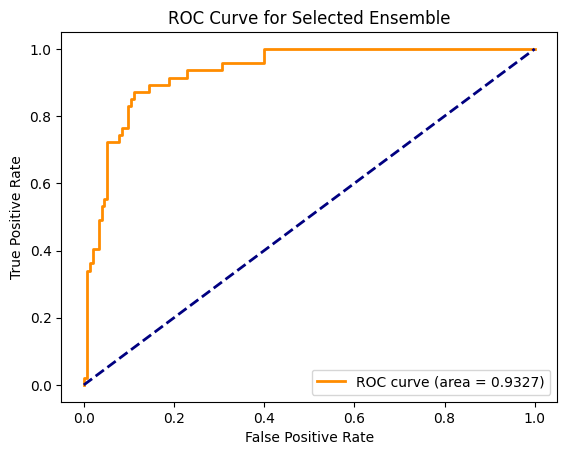

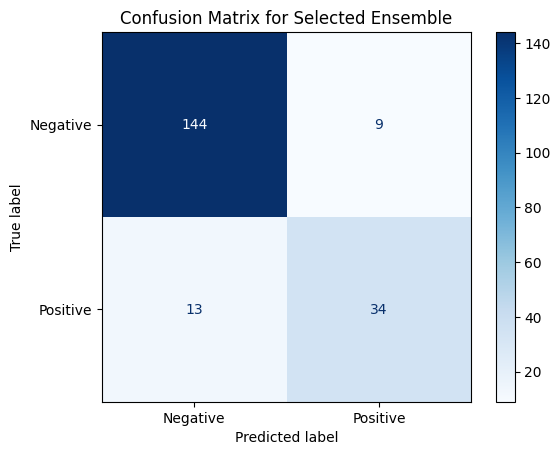

In [6]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Load preprocessed data
X_resampled = pd.read_csv('/kaggle/working/X_resampled_adasyn.csv')
y_resampled = np.load('/kaggle/working/y_resampled_adasyn.npy')
X_test = pd.read_csv('/kaggle/working/X_test.csv')
y_test = np.load('/kaggle/working/y_test.npy')

# Load all classifiers
classifiers = {
    'SVM': joblib.load('/kaggle/working/SVM_adasyn_best_classifier.joblib'),
    'Random_Forest': joblib.load('/kaggle/working/Random_Forest_adasyn_best_classifier.joblib'),
    'Neural_Network': joblib.load('/kaggle/working/Neural_Network_adasyn_best_classifier.joblib'),
    'Decision_Tree': joblib.load('/kaggle/working/Decision_Tree_adasyn_best_classifier.joblib'),
    'KNN': joblib.load('/kaggle/working/KNN_adasyn_best_classifier.joblib'),
    'Naive_Bayes': joblib.load('/kaggle/working/Naive_Bayes_adasyn_best_classifier.joblib'),
    'Logistic_Regression': joblib.load('/kaggle/working/Logistic_Regression_adasyn_best_classifier.joblib')
}

# Function to calculate diversity (e.g., pairwise agreement)
def calculate_diversity(classifiers, X):
    predictions = np.array([clf.predict(X) for clf in classifiers.values()])
    pairwise_agreements = np.mean([np.mean(predictions[i] == predictions[j]) for i in range(len(predictions)) for j in range(i+1, len(predictions))])
    return 1 - pairwise_agreements  # Diversity as 1 - agreement

# Dynamic ensemble selection
def dynamic_ensemble_selection(classifiers, X_val, y_val, threshold=0.83, diversity_threshold=0.1):
    performance_scores = {name: accuracy_score(y_val, clf.predict(X_val)) for name, clf in classifiers.items()}
    selected_classifiers = {name: clf for name, clf in classifiers.items() if performance_scores[name] > threshold}
    
    # Check diversity
    if len(selected_classifiers) > 1:
        diversity = calculate_diversity(selected_classifiers, X_val)
        if diversity < diversity_threshold:
            worst_model = min(selected_classifiers, key=performance_scores.get)
            del selected_classifiers[worst_model]
    
    # Return selected classifiers and their performance scores
    return selected_classifiers, performance_scores

# Apply Dynamic Ensemble Selection
selected_classifiers, performance_scores = dynamic_ensemble_selection(classifiers, X_test, y_test, threshold=0.83, diversity_threshold=0.1)

# Print selected models and their performance scores
print("Selected Models and their Performance Scores:")
for name, score in performance_scores.items():
    print(f"Model: {name}, Accuracy: {score:.4f}")

# Print names of the selected models
print("\nSelected Models for Ensemble:")
for name in selected_classifiers.keys():
    print(name)

# Define and train the new ensemble with selected classifiers
selected_ensemble = VotingClassifier(estimators=[
    (name, clf) for name, clf in selected_classifiers.items()
], voting='soft')

selected_ensemble.fit(X_resampled, y_resampled)

# Evaluate the selected ensemble
y_pred_selected = selected_ensemble.predict(X_test)
y_pred_proba_selected = selected_ensemble.predict_proba(X_test)[:, 1]

# Calculate accuracy
final_selected_accuracy = accuracy_score(y_test, y_pred_selected)
print(f'Final Selected Ensemble Accuracy: {final_selected_accuracy:.4f}')

# Print classification report (including precision, recall, and F1-score)
print("\nClassification Report for Selected Ensemble:")
print(classification_report(y_test, y_pred_selected, target_names=['Negative', 'Positive']))

# Print ROC AUC score
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_selected)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_selected:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selected Ensemble')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curve_selected_ensemble.png')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_selected)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Selected Ensemble')
plt.savefig('/kaggle/working/confusion_matrix_selected_ensemble.png')
plt.show()


# Hyperparameter for Ensemble model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters found: {'voting': 'hard', 'weights': [1, 1, 1, 1, 1]}
Best cross-validation score: 0.9548
Final Selected Ensemble Accuracy: 0.8850

Classification Report for Tuned Ensemble:
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93       153
    Positive       0.77      0.72      0.75        47

    accuracy                           0.89       200
   macro avg       0.84      0.83      0.84       200
weighted avg       0.88      0.89      0.88       200



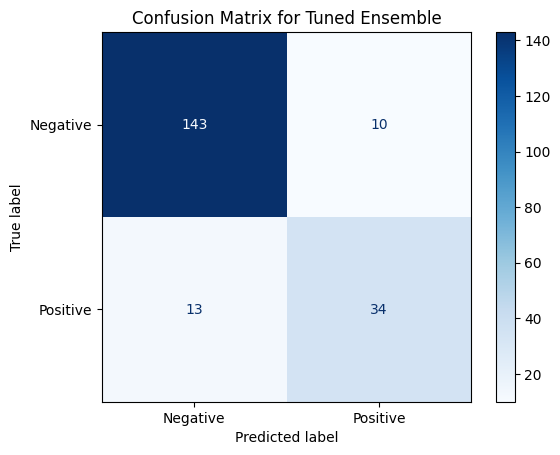

['/kaggle/working/best_ensemble_classifier.joblib']

In [8]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load preprocessed data
X_resampled = pd.read_csv('/kaggle/working/X_resampled_adasyn.csv')
y_resampled = np.load('/kaggle/working/y_resampled_adasyn.npy')
X_test = pd.read_csv('/kaggle/working/X_test.csv')
y_test = np.load('/kaggle/working/y_test.npy')

# Load all classifiers
classifiers = {
    'SVM': joblib.load('/kaggle/working/SVM_adasyn_best_classifier.joblib'),
    'Random_Forest': joblib.load('/kaggle/working/Random_Forest_adasyn_best_classifier.joblib'),
    'Neural_Network': joblib.load('/kaggle/working/Neural_Network_adasyn_best_classifier.joblib'),
    'Decision_Tree': joblib.load('/kaggle/working/Decision_Tree_adasyn_best_classifier.joblib'),
    'KNN': joblib.load('/kaggle/working/KNN_adasyn_best_classifier.joblib'),
    'Naive_Bayes': joblib.load('/kaggle/working/Naive_Bayes_adasyn_best_classifier.joblib'),
    'Logistic_Regression': joblib.load('/kaggle/working/Logistic_Regression_adasyn_best_classifier.joblib')
}

# Apply Dynamic Ensemble Selection
selected_classifiers, performance_scores = dynamic_ensemble_selection(classifiers, X_test, y_test, threshold=0.83, diversity_threshold=0.1)

# Define the VotingClassifier with the selected classifiers
selected_ensemble = VotingClassifier(estimators=[
    (name, clf) for name, clf in selected_classifiers.items()
], voting='soft')  # Default to soft voting for this example

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'voting': ['hard', 'soft'],  # Try both hard and soft voting
    'weights': [  # Test different weights configurations
        [1] * len(selected_classifiers),  # Equal weights
        [1, 2, 1, 1],  # Example configuration: Adjust these based on the number of classifiers
        [2, 1, 1, 1],
        [1, 1, 2, 1],
    ]
}

# Perform grid search to find the best voting strategy and weights
grid_search = GridSearchCV(estimator=selected_ensemble, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best Voting Classifier after tuning
best_ensemble = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the best ensemble on the test set
y_pred_selected = best_ensemble.predict(X_test)

# Calculate accuracy
final_selected_accuracy = accuracy_score(y_test, y_pred_selected)
print(f'Final Selected Ensemble Accuracy: {final_selected_accuracy:.4f}')

# If the best voting strategy is soft, calculate and plot ROC AUC
if grid_search.best_params_['voting'] == 'soft':
    y_pred_proba_selected = best_ensemble.predict_proba(X_test)[:, 1]
    roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_selected)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_selected:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Tuned Ensemble')
    plt.legend(loc="lower right")
    plt.savefig('/kaggle/working/roc_curve_tuned_ensemble.png')
    plt.show()

# Print classification report
print("\nClassification Report for Tuned Ensemble:")
print(classification_report(y_test, y_pred_selected, target_names=['Negative', 'Positive']))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_selected)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Tuned Ensemble')
plt.savefig('/kaggle/working/confusion_matrix_tuned_ensemble.png')
plt.show()

# Save the best ensemble model
joblib.dump(best_ensemble, '/kaggle/working/best_ensemble_classifier.joblib')
